In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
# Define the parameters
start = "2019-01-01"
end = "2022-12-31"
company = ['^GSPC']

# Download historical data
stock = yf.download(company, start=start, end=end)
df = stock.copy()

df.reset_index(inplace=True)
date_column = df['Date']

df.head()


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3733160000
1,2019-01-03,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3858830000
2,2019-01-04,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4234140000
3,2019-01-07,2535.610107,2566.159912,2524.560059,2549.689941,2549.689941,4133120000
4,2019-01-08,2568.110107,2579.820068,2547.560059,2574.409912,2574.409912,4120060000


In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Normalization
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X,y = [], []
sequence_length = 50
for i in range(len(df) - sequence_length):
    X.append(df['Close'].iloc[i:i+sequence_length].values)
    y.append(df['Close'].iloc[i + sequence_length])

X,y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [8]:
print("Performance (R^2): ", lr.score(X_train, y_train))

Performance (R^2):  0.9944061925684453


In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [8]:
from keras.callbacks import EarlyStopping


In [9]:
X_test = X_test[-200:]  # Keep the last 200 sequences

# Define the number of LSTM layers
num_lstm_layers = 2

# Build the LSTM model with multiple LSTM layers
model = Sequential()
for _ in range(num_lstm_layers):
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions
y_pred = model.predict(X_test)

y_test_actual = y_test[-200:]
y_pred_actual = y_pred[-200:]



Epoch 1/50

24/24 [==============================] - 3s 43ms/step - loss: 0.2071 - val_loss: 0.0070
Epoch 2/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0132 - val_loss: 0.0094
Epoch 3/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 4/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 5/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 6/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/50
24/24 [==============================] - 1s 30ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 8/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 9/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/50
24/24 [==============================] - 1s 31ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [11]:
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)


print(f'Root Mean Squared Error (RMSE): {rmse: .6f}')
print(f'Mean Absolute Error (MAE): {mae: .6f}')
print(f'R-squared (R2) Score: {r2: .6f}')


Root Mean Squared Error (RMSE):  0.030170
Mean Absolute Error (MAE):  0.023629
R-squared (R2) Score:  0.984752


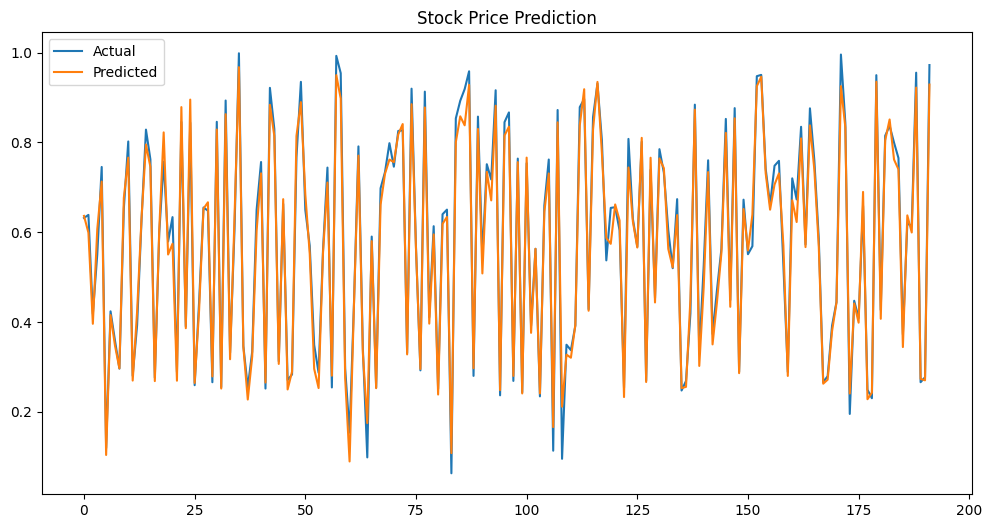

In [12]:
# Plot the actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.legend()
plt.title('Stock Price Prediction')
plt.show()